# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.colors import hsv_to_rgb
from matplotlib.collections import PatchCollection

import shapefile

from geopy import distance

# Per-Patient CSC Allocations

This graphic plots which CSC a patient went to if they either initially went to a CSC, or if they were subsequently transferred for angiography. Note that patients do *do not always* go to the closest hospital as their initial hospital.

Note: this *only* shows patients which ended up going to a CSC.

In [2]:
def plot_csc(df, csc_data, zoom_scale, show_hospitals=True):
    """ Plots per-patient CSC allocations.
    
    Args:
        df (Pandas.DataFrame): simulation data
        zoom_scale (float)
    
    """
    centre = [-37.8, 145]
    bbox = [centre[0]-zoom_scale, centre[0]+zoom_scale,
            centre[1]-zoom_scale, centre[1]+zoom_scale]

    plt.figure(figsize=(12,12))
    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    m.drawcoastlines()
    m.fillcontinents(alpha=0.1)
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0], color="#cccccc")
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=90, color="#cccccc")
    m.drawmapboundary(fill_color='white')

    def convert(origin_latitude, origin_longitude):
        return m(origin_longitude, origin_latitude)

    m_coords = []

    for csc in csc_data.name:
        subset = df[(df.hospital_of_arrival == csc) | (df.hospital_of_transfer == csc)]
        m_coords.append(subset[['stroke_location_latitude','stroke_location_longitude']].apply(lambda x: convert(*x), axis=1))

    axes = []
    
    # Submission only colour modifications, as per request.
    colours = {
        "Austin Health": (1,0.6,0.6),
        "Monash Health": (0.6,1,0.6),
        "Royal Melbourne Hospital": (0.6,0.6,1)
    }
    
    #colours = [(1,0.6,0.6), (0.6,1,0.6), (0.6,0.6,1)]
    for i, cs in enumerate(m_coords):
        xs = [c[0] for c in cs]
        ys = [c[1] for c in cs]
        name = csc_data.iloc[i]["name"]
        axes.append(m.scatter(xs,ys,marker='D',c=colours[name], s=4/zoom_scale, alpha=0.9))
    
    # Submission only name modifications, as per request.
    renamed = csc_data.copy(deep=True)
    renamed.loc[0, "name"] = "Austin Hospital"
    renamed.loc[1, "name"] = "Monash Medical Centre"
    
    if show_hospitals:
        hosp_coords = csc_data[['latitude', 'longitude']].apply(lambda x: convert(*x), axis=1)
        for i, c in enumerate(hosp_coords):
            min_c = convert(bbox[0], bbox[2])
            max_c = convert(bbox[1], bbox[3])
            if c[0] > min_c[0] and c[0] < max_c[0] and c[1] > min_c[1] and c[1] < max_c[1]:
                m.plot(c[0], c[1], 'r*')
                plt.text(c[0], c[1], renamed.iloc[i]["name"], fontsize=12)
    else:
        plt.legend(axes, renamed.name)

    plt.show()

## 3 CSC Hospitals

In [5]:
filepath = "../data/processed/2019_06_30_0115_3_3hosp_vicsim_simdata.csv"
df_3 = pd.read_csv(filepath)

In [6]:
hospital_data = pd.read_csv('../../data/processed/hospital_data.csv')

In [7]:
# Data doesn't currently contain central, peripheral or rural identifiers
csc_data_3 = hospital_data[(hospital_data.name == "Austin Health") |
                         (hospital_data.name == "Monash Health") |
                         (hospital_data.name == "Royal Melbourne Hospital")
                        ]

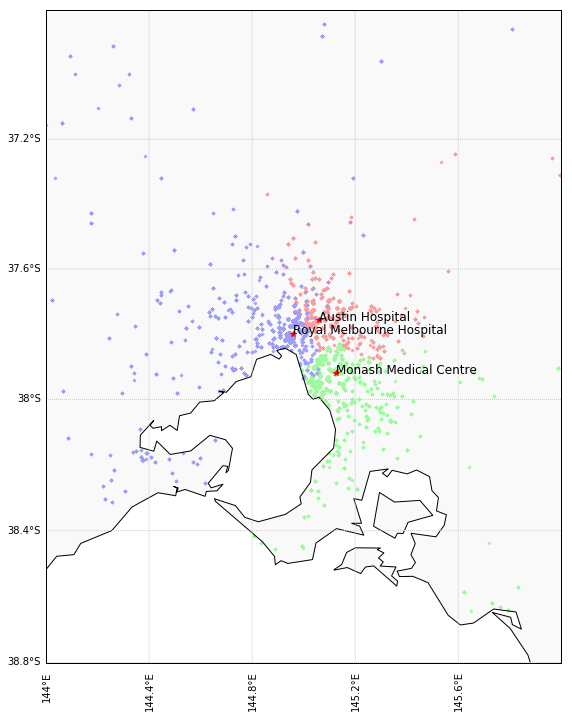

In [8]:
plot_csc(df_3, csc_data_3, 1)

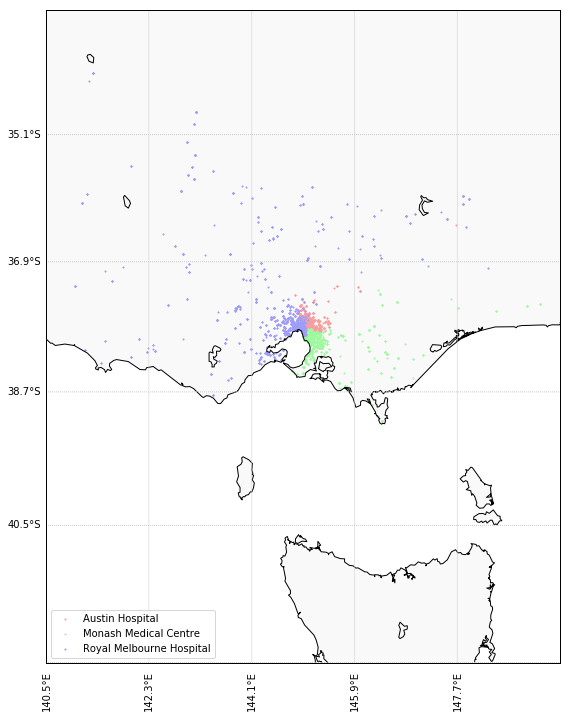

In [9]:
plot_csc(df_3, csc_data_3, 4.5, show_hospitals=False)

## 2 CSC Hospitals

In [10]:
filepath = "../data/processed/2019_06_30_0112_3_2hosp_vicsim_simdata.csv"
df_2 = pd.read_csv(filepath)

In [11]:
# Data doesn't currently contain central, peripheral or rural identifiers
csc_data_2 = hospital_data[(hospital_data.name == "Monash Health") |
                         (hospital_data.name == "Royal Melbourne Hospital")
                        ]

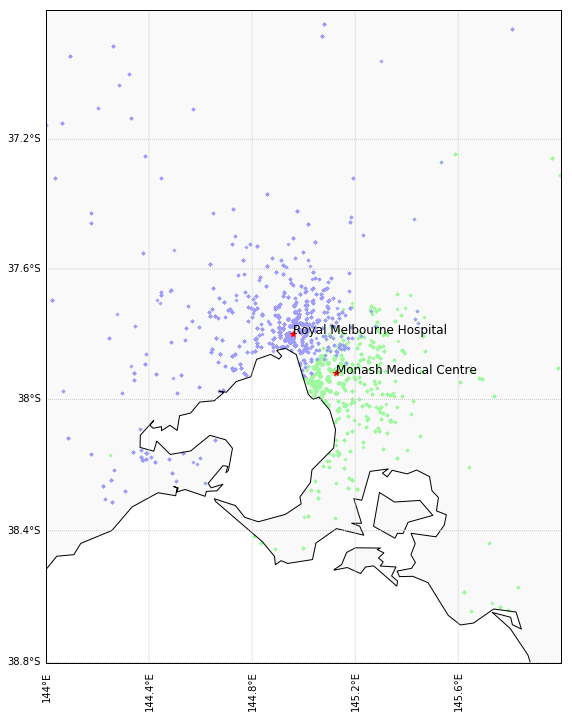

In [12]:
plot_csc(df_2, csc_data_2, 1)

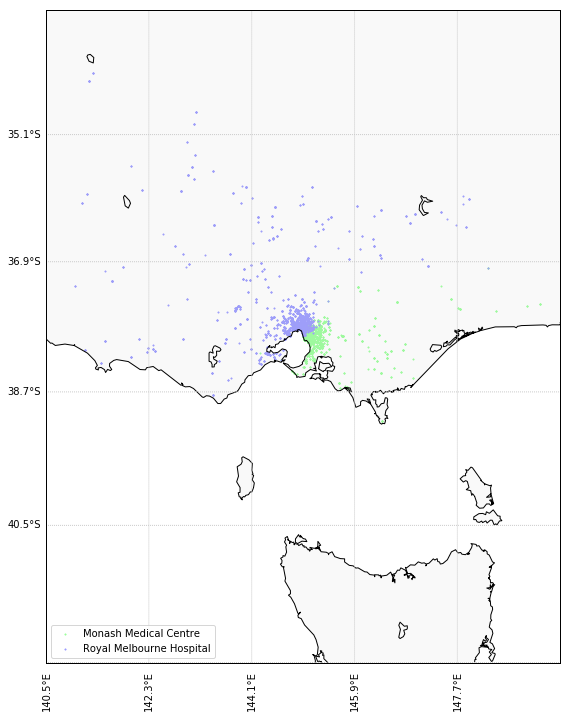

In [13]:
plot_csc(df_2, csc_data_2, 4.5, show_hospitals=False)

# Population per SED

Shown as a proportion of the maximum SED population.

Shape data:

In [35]:
external_data_dir = '../../data/external/2016_SED_shape/'
filename_base = 'SED_2016_AUST'

shape_data = shapefile.Reader(external_data_dir + filename_base)
all_shapes = shape_data.shapeRecords()

vic_shapes = [shape for shape in all_shapes if shape.record[4] == 'Victoria' ]

Census data:

In [36]:
external_census_dir = '../../data/external/2016_GCP_SED_for_Vic_short-header/2016 Census GCP State Electoral Divisions for VIC/'
census_data_files = os.listdir(external_census_dir)

g01_data = pd.read_csv(external_census_dir + '2016Census_G01_VIC_SED.csv')

In [37]:
max_population = max(g01_data.Tot_P_P)
min_population = min(g01_data.Tot_P_P)

Plotting:

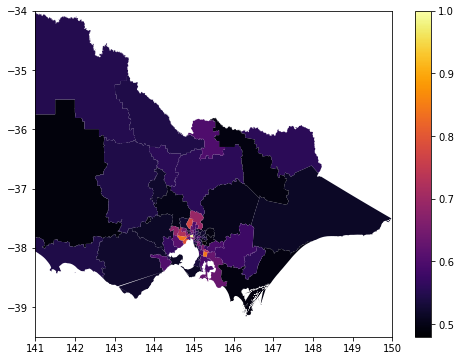

In [41]:

fig, axes=plt.subplots(figsize=(8,6))

patch_list = []
colors = []

for shape in vic_shapes[:-2]:
    all_points = shape.shape.points

    xy = np.array(all_points)

    sed = shape.record[0]
    population = g01_data[g01_data.SED_CODE_2016 == sed].Tot_P_P

    value = population.iloc[0] / max_population
    colors.append(value)

    polygon = Polygon(xy, True)
    patch_list.append(polygon)

collection = PatchCollection(patch_list, alpha=1, cmap="inferno")
collection.set_array(np.array(colors))
fig.colorbar(collection, ax=axes)
axes.add_collection(collection)

axes.set_xlim([141, 150])
axes.set_ylim([-39.5, -34])

plt.show()

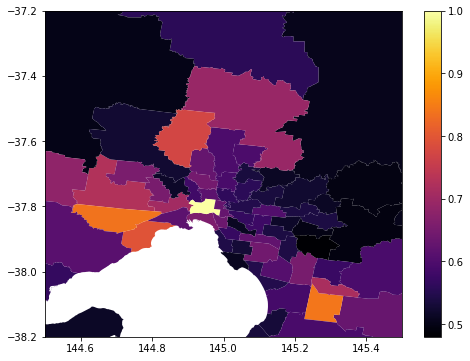

In [42]:
axes.set_xlim([144.5, 145.5])
axes.set_ylim([-38.2, -37.2])
fig